# Andrew's model work for Milestone 4, based on David's

In [662]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [663]:
### specify processed data files to generate - full/partial, partial %, and train/test
### Note: this cell is the same in both notebooks

# load and clean full dataset?
#load_full = False
load_full = True  # AMG

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

if load_full:
    pct_str = ""
else: # not load_full
    pct_str = str(sample_percent) + "_pct"
    
# use training or testing data to generate minor files?
minor_use_train = True
if minor_use_train:
    mode_str = "train"
else: # not minor_use_train
    mode_str = "test"
    
### set intermediate file names
dir_str = "./intermediate_files/"

processed_data_train_file = dir_str + "processed_data_" + "train" + pct_str + ".json"
processed_data_test_file = dir_str + "processed_data_" + "test" + pct_str + ".json"

nlp_data_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
nlp_data_train_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
term_freqs_file = dir_str + "term_freqs_" + mode_str + pct_str + ".mtx"
diff_terms_file = dir_str + "diff_terms_" + mode_str + pct_str + ".json"

In [664]:
processed_data_train_file

'./intermediate_files/processed_data_train.json'

In [665]:
### load processed data
data = pd.read_json(processed_data_train_file)
data_nlp = pd.read_json(nlp_data_file)
desc_matrix_coo = mmread(term_freqs_file)
desc_matrix = sp.sparse.csr_matrix(desc_matrix_coo)
count_cols_df = pd.read_json(diff_terms_file)

count_cols_bool = count_cols_df.values > 0.0

In [666]:
print len(data)

173805


In [667]:
model_loan_term = 36
data_filtered = data[data.loan_term == model_loan_term]
data_filtered = data_filtered[pd.to_datetime(data_filtered.issue_date).dt.year.isin([2011,2012,2013])]
print len(data_filtered)

79052


In [668]:
model_loan_term = 36

In [669]:
pd.to_datetime(data_filtered.issue_date).dt.year.value_counts()

2013    38957
2012    30170
2011     9925
Name: issue_date, dtype: int64

In [670]:
# del x['verif_status']
data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,79052.0,6.903144e+04,5.626822e+04,5.000000e+03,4.200000e+04,6.000000e+04,8.400000e+04,7.141778e+06
cpi,79052.0,2.129961e-02,4.217134e-04,2.069586e-02,2.092454e-02,2.132448e-02,2.166709e-02,2.224093e-02
delinq_2_yrs,79052.0,1.832085e-01,4.819232e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
desc_len,38614.0,2.499745e+02,2.132272e+02,1.000000e+00,NaN,NaN,NaN,4.544000e+03
dti,79052.0,2.437067e-03,1.136559e-03,0.000000e+00,1.575150e-03,2.392426e-03,3.267855e-03,5.445891e-03
gdp,79052.0,9.997262e-01,3.283828e-05,9.995987e-01,9.997036e-01,9.997311e-01,9.997524e-01,9.997853e-01
id,79052.0,3.620877e+06,2.750039e+06,5.852400e+04,1.341303e+06,2.380480e+06,5.875565e+06,1.023482e+07
inquiry_6_mos,79052.0,7.952866e-01,9.543483e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00
installment,79052.0,3.986631e+02,2.455526e+02,3.016000e+01,2.190400e+02,3.433900e+02,5.150800e+02,1.408130e+03
interest_rate,79052.0,1.283620e+01,3.946880e+00,5.420000e+00,9.990000e+00,1.299000e+01,1.561000e+01,2.589000e+01


In [671]:
# earliest_credit is not really a good indicator -- we want to know how long has elapsed since then
# See http://stackoverflow.com/questions/17414130/pandas-datetime-calculate-number-of-weeks-between-dates-in-two-columns
data_filtered['months_since_earliest_credit'] = (
    (pd.to_datetime(data_filtered.issue_date) - pd.to_datetime(data_filtered.earliest_credit))/np.timedelta64(1,'M')
).round()

In [672]:
data_filtered.columns

Index([               u'address_state',                u'annual_income',
                                u'cpi',                 u'delinq_2_yrs',
                           u'desc_len',                  u'description',
                                u'dti',              u'earliest_credit',
                      u'employ_length',                 u'employ_title',
                                u'gdp',                   u'home_owner',
                                 u'id',          u'initial_list_status',
                      u'inquiry_6_mos',                  u'installment',
                      u'interest_rate',                          u'ipr',
                         u'issue_date',                  u'loan_amount',
                       u'loan_purpose',                  u'loan_status',
                      u'loan_subgrade',                    u'loan_term',
           u'months_since_last_record',                u'open_accounts',
                         u'recoveries',            

In [673]:
data_filtered_x = data_filtered.drop('loan_status', 1)
data_filtered_y = data_filtered['loan_status']

In [674]:
# copy unstandardized columns for later revenue calculation
installments = data_filtered.installment
loan_amounts = data_filtered.loan_amount
recoveries_avg = data_filtered.recoveries.sum() / np.count_nonzero(data_filtered.recoveries)

In [675]:
def expand_x(x, x_orig):
    x_expanded = pd.DataFrame()
    for colname in x_orig.columns:
        if colname in ('description', 'verif_status', 'loan_subgrade', 'id', 'interest_rate'
                       'index', 'recoveries', 'issue_date', 'earliest_credit'):
            continue
        print colname, x_orig[colname].dtype
        if x_orig[colname].dtype == 'object':
            values = x[colname].fillna('MISSING')
            value_columns = x_orig[colname].fillna('MISSING').value_counts().index
            if len(value_columns) > 50:
                value_columns = value_columns[:50]
            for val in value_columns:
                x_expanded[colname + '__' + val.replace(' ', '_')] = (values == val).astype(int)
        else:
            values = x[colname].fillna(x[colname].median())
            sd = np.nanstd(x_orig[colname])
            if sd < 1e-10:
                sd = 1
            x_expanded[colname] = (values - np.nanmean(x_orig[colname]))/sd
    return x_expanded

In [676]:
data_filtered_expanded_x = expand_x(data_filtered_x, data_filtered_x)

address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
employ_title object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
installment float64
interest_rate float64
ipr float64
loan_amount int64
loan_purpose object
loan_term int64
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
months_since_earliest_credit float64


In [677]:
data_filtered_expanded_x.describe().T

,count,mean,std,min,25%,50%,75%,max
address_state__CA,79052.0,1.799828e-01,0.384176,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__NY,79052.0,8.838486e-02,0.283856,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__TX,79052.0,7.741740e-02,0.267254,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__FL,79052.0,7.221829e-02,0.258851,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__IL,79052.0,3.800030e-02,0.191198,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__NJ,79052.0,3.712746e-02,0.189075,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__PA,79052.0,3.153620e-02,0.174763,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__GA,79052.0,2.996762e-02,0.170499,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__VA,79052.0,2.973992e-02,0.169870,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__OH,79052.0,2.920862e-02,0.168392,0.000000,0.000000,0.000000,0.000000,1.000000


In [678]:
data_filtered_expanded_x.columns

Index([             u'address_state__CA',              u'address_state__NY',
                    u'address_state__TX',              u'address_state__FL',
                    u'address_state__IL',              u'address_state__NJ',
                    u'address_state__PA',              u'address_state__GA',
                    u'address_state__VA',              u'address_state__OH',
       ...
                  u'loan_purpose__house', u'loan_purpose__renewable_energy',
                            u'loan_term',       u'months_since_last_record',
                        u'open_accounts',                     u'revol_util',
                                  u'rir',                 u'total_accounts',
                             u'unemploy',   u'months_since_earliest_credit'],
      dtype='object', length=149)

### Split Data

In [679]:
# Get a more manageable sample
np.random.seed(1729)
sample_flags = np.random.random(len(data_filtered_expanded_x)) <= 0.25
print "Indexes computed" 

# train set
x_expanded = data_filtered_expanded_x.iloc[sample_flags, :]
print len(x)

# test set
x_test_expanded = data_filtered_expanded_x.iloc[~sample_flags, :]
print len(x_test)

Indexes computed
19719
59333


In [680]:
# split response column
y = data_filtered_y.iloc[sample_flags]
y_test = data_filtered_y.iloc[~sample_flags]

In [681]:
# split NLP data into predictors and response
x_nlp = data_nlp.drop('loan_status', 1)
y_nlp = data_nlp['loan_status']

In [682]:
# inspect test proportion of good/bad loans
y_test.value_counts()

False    50334
True      8999
Name: loan_status, dtype: int64

In [683]:
# verify size of train set
np.count_nonzero(x_expanded.loan_amount)

19719

In [684]:
# be prepared to split stuff up by year of issue
years = pd.to_datetime(data_filtered_x.issue_date.iloc[sample_flags]).dt.year
years_test = pd.to_datetime(data_filtered_x.issue_date.iloc[~sample_flags]).dt.year

### Apply PCA to predictors

In [685]:
tsvd = tSVD(n_components = 100)
data_filtered_expanded_x_pca = pd.DataFrame(tsvd.fit_transform(data_filtered_expanded_x))
data_filtered_expanded_x_pca.index = data_filtered_expanded.index
pca_cum_var_expl = np.cumsum(np.round(tsvd.explained_variance_ratio_, 4) * 100)

In [686]:
print np.where(pca_cum_var_expl >= 99)

x_expanded_pca = data_filtered_expanded_x_pca.iloc[sample_flags, :73]
x_test_expanded_pca = data_filtered_expanded_x_pca.iloc[~sample_flags, :73]

(array([62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
       96, 97, 98, 99]),)


# Start evaluating models

In [687]:
#for yr in set(years.values):
#    rf = RFC(random_state=1729,
#             max_depth=5,
#             n_estimators=100,
#             oob_score=True
#            ).fit(x_expanded[years==yr], y[years==yr])
#    print "%d  oob score: %.3f  baseline: %.3f" % (yr, rf.oob_score_, 1-y[years==yr].mean(),)

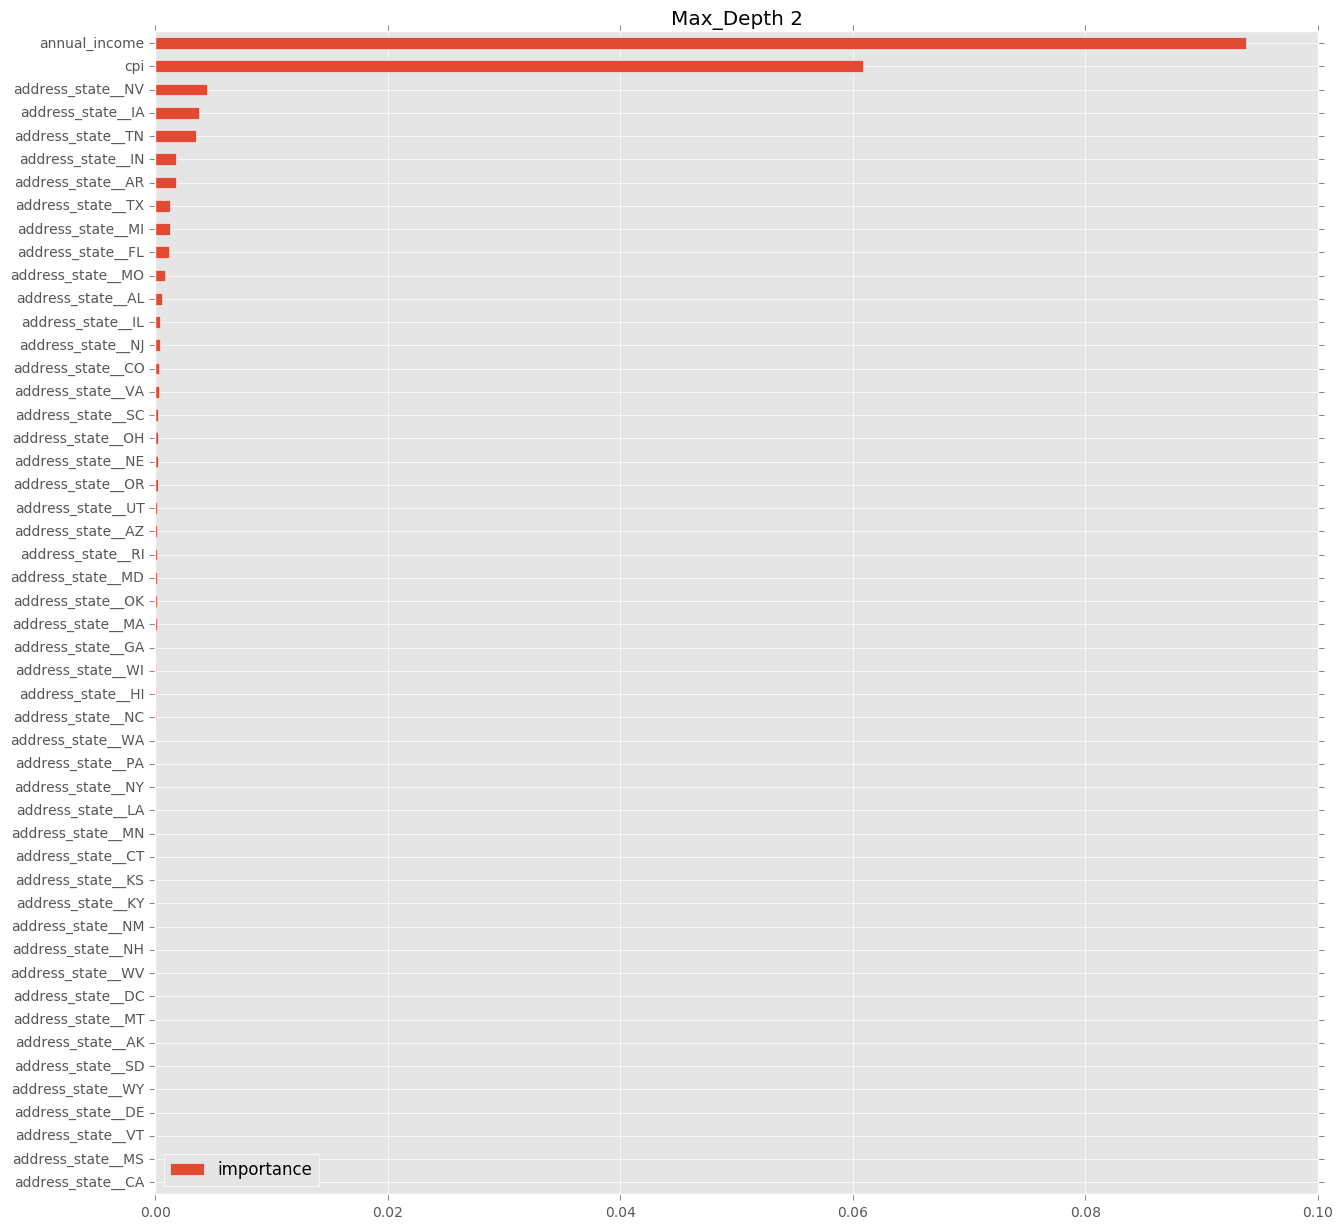

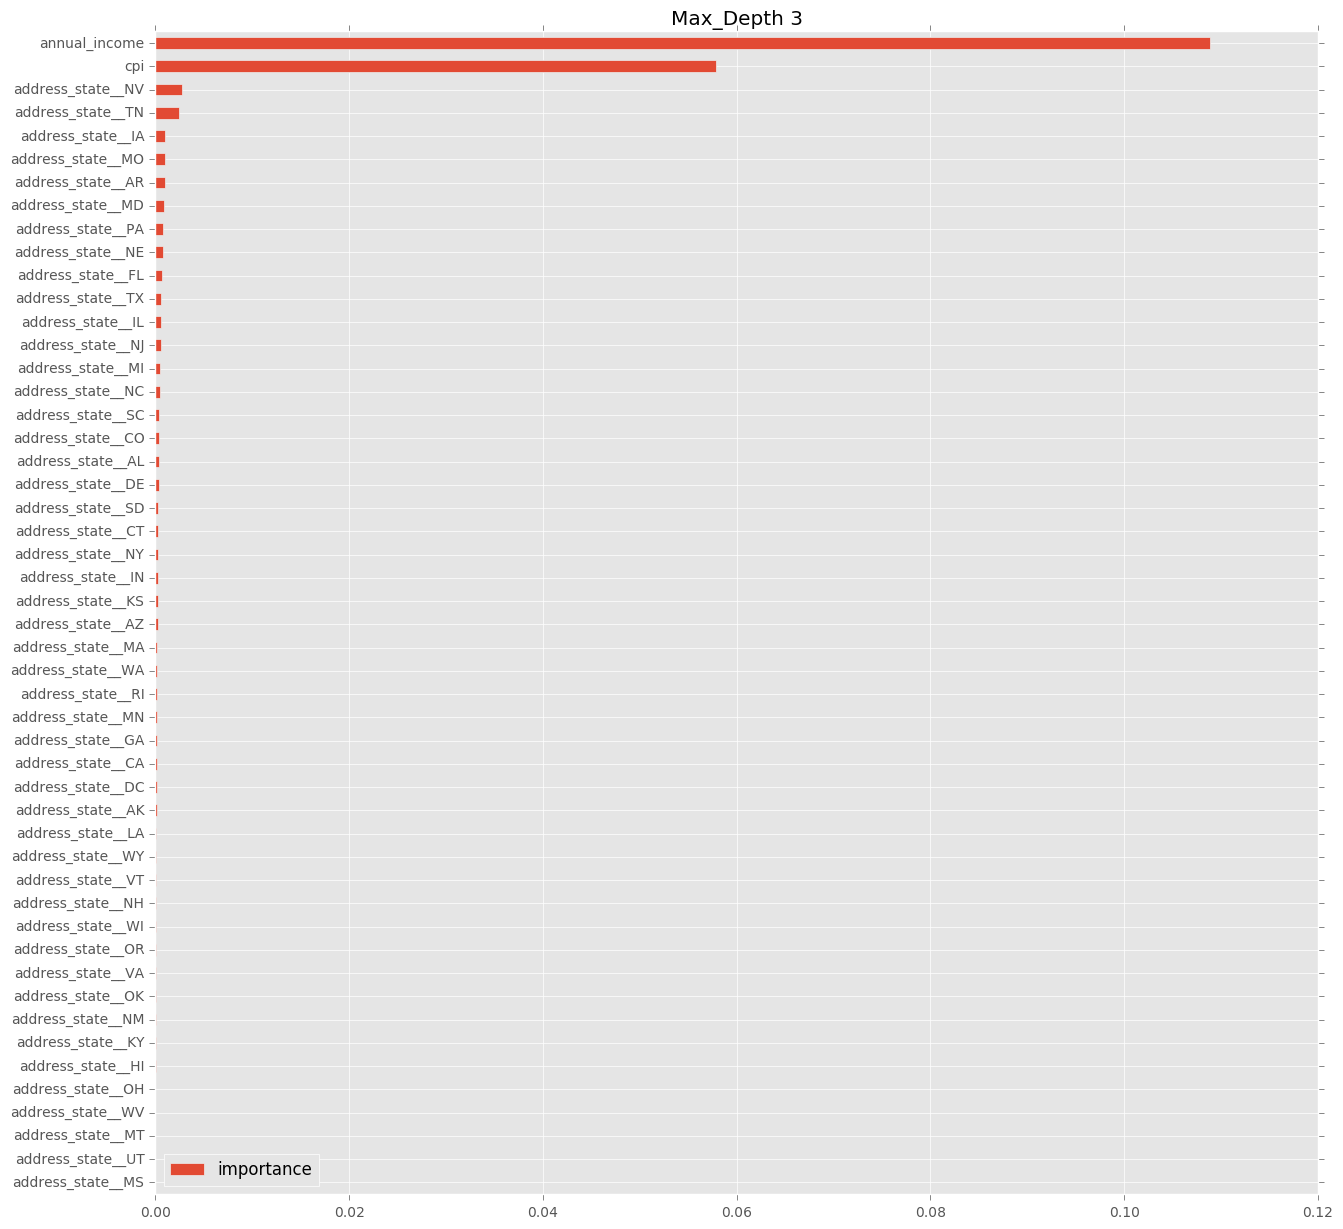

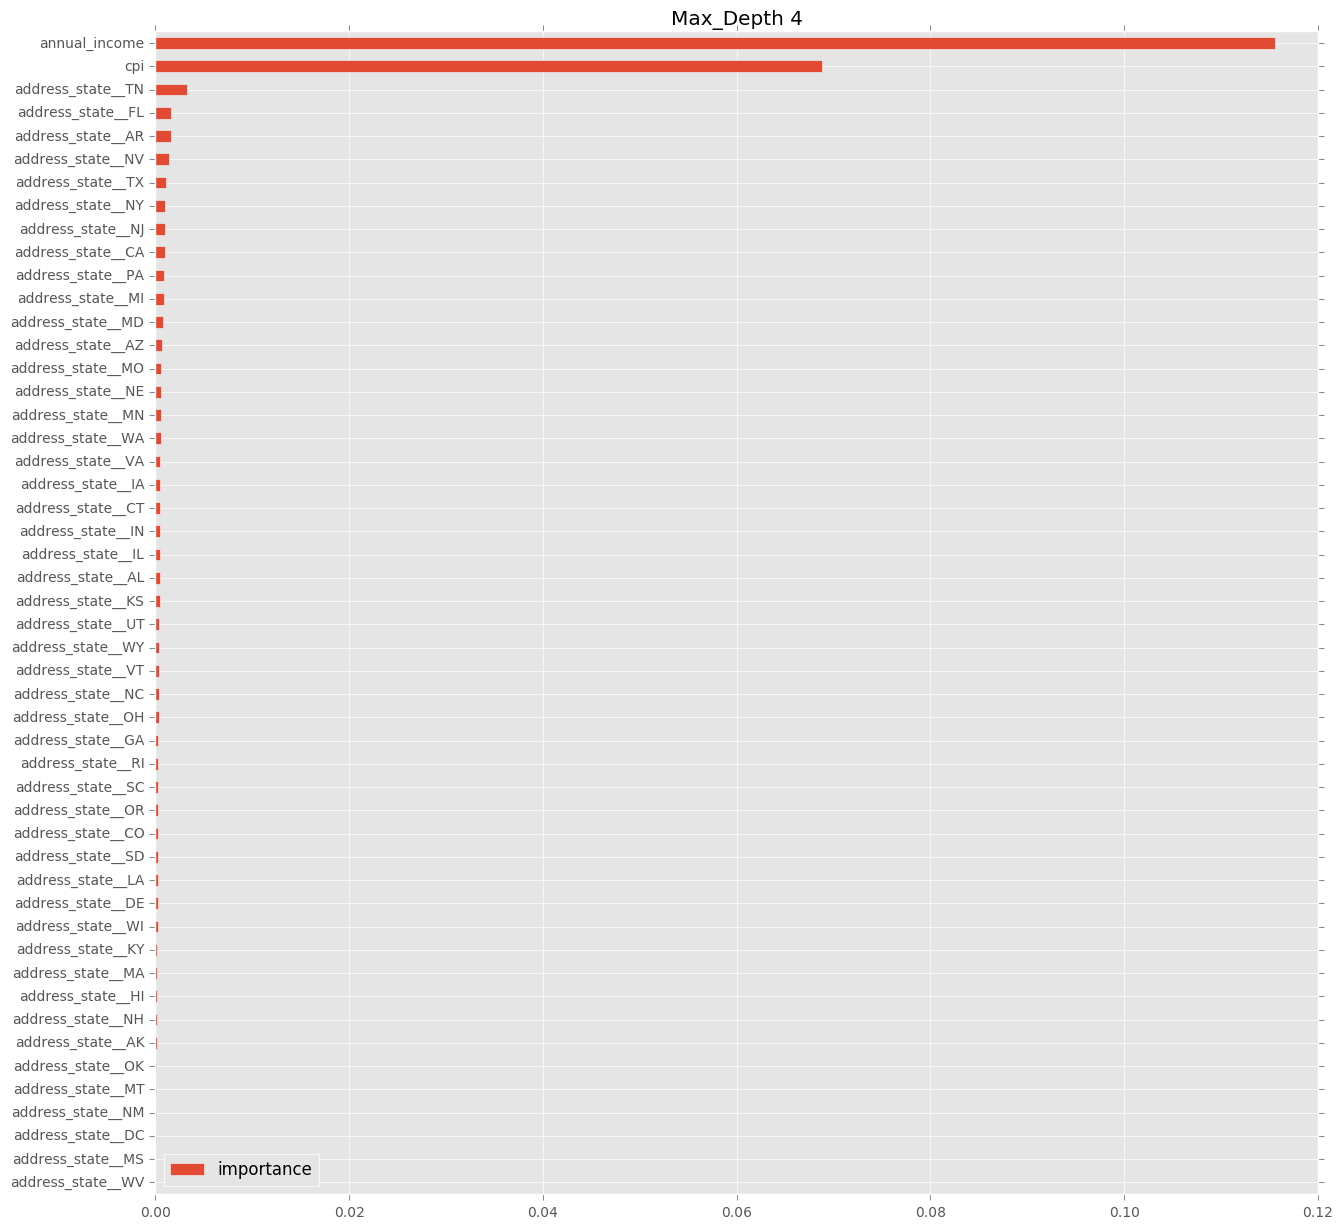

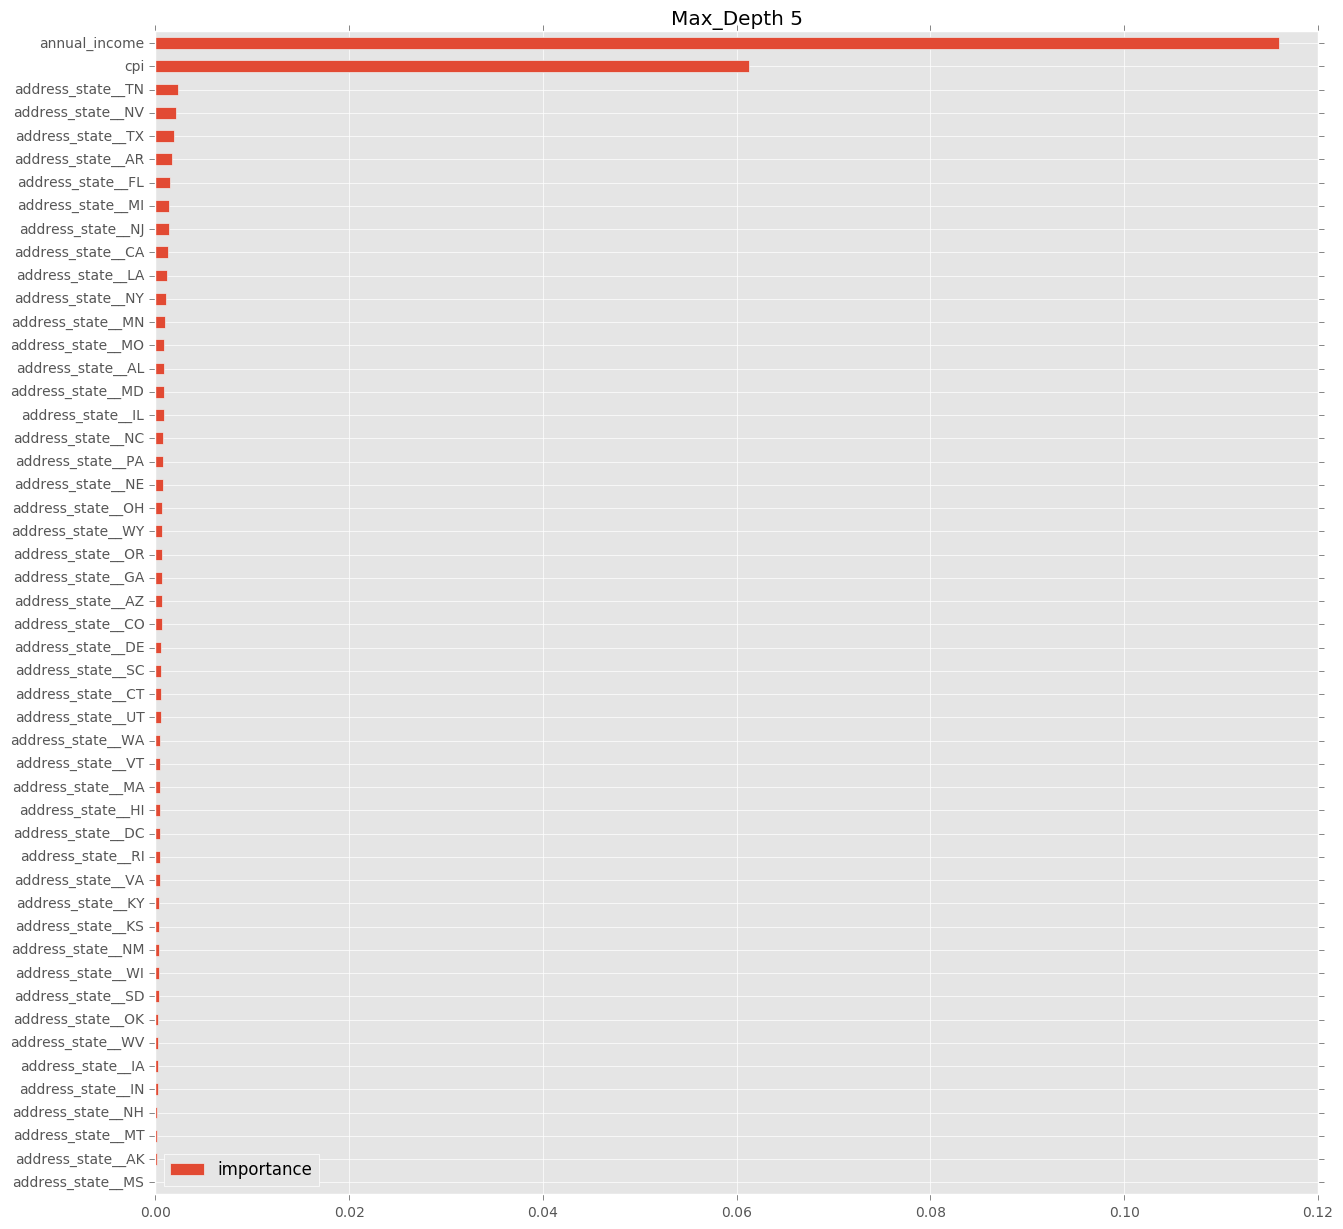

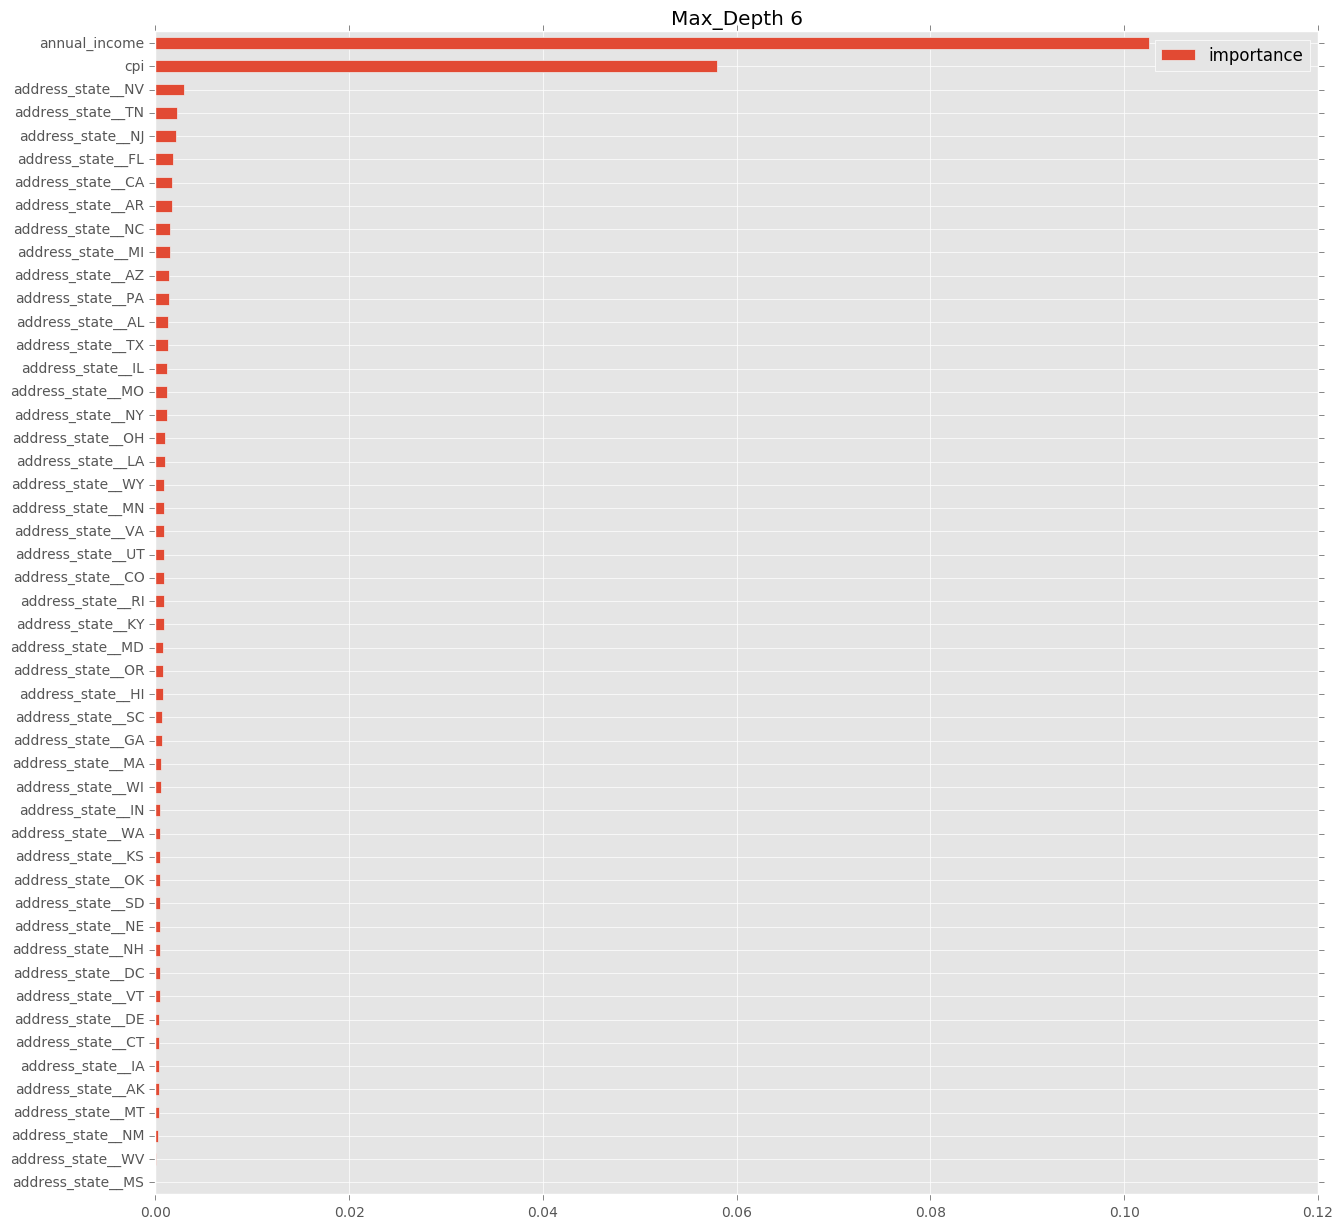

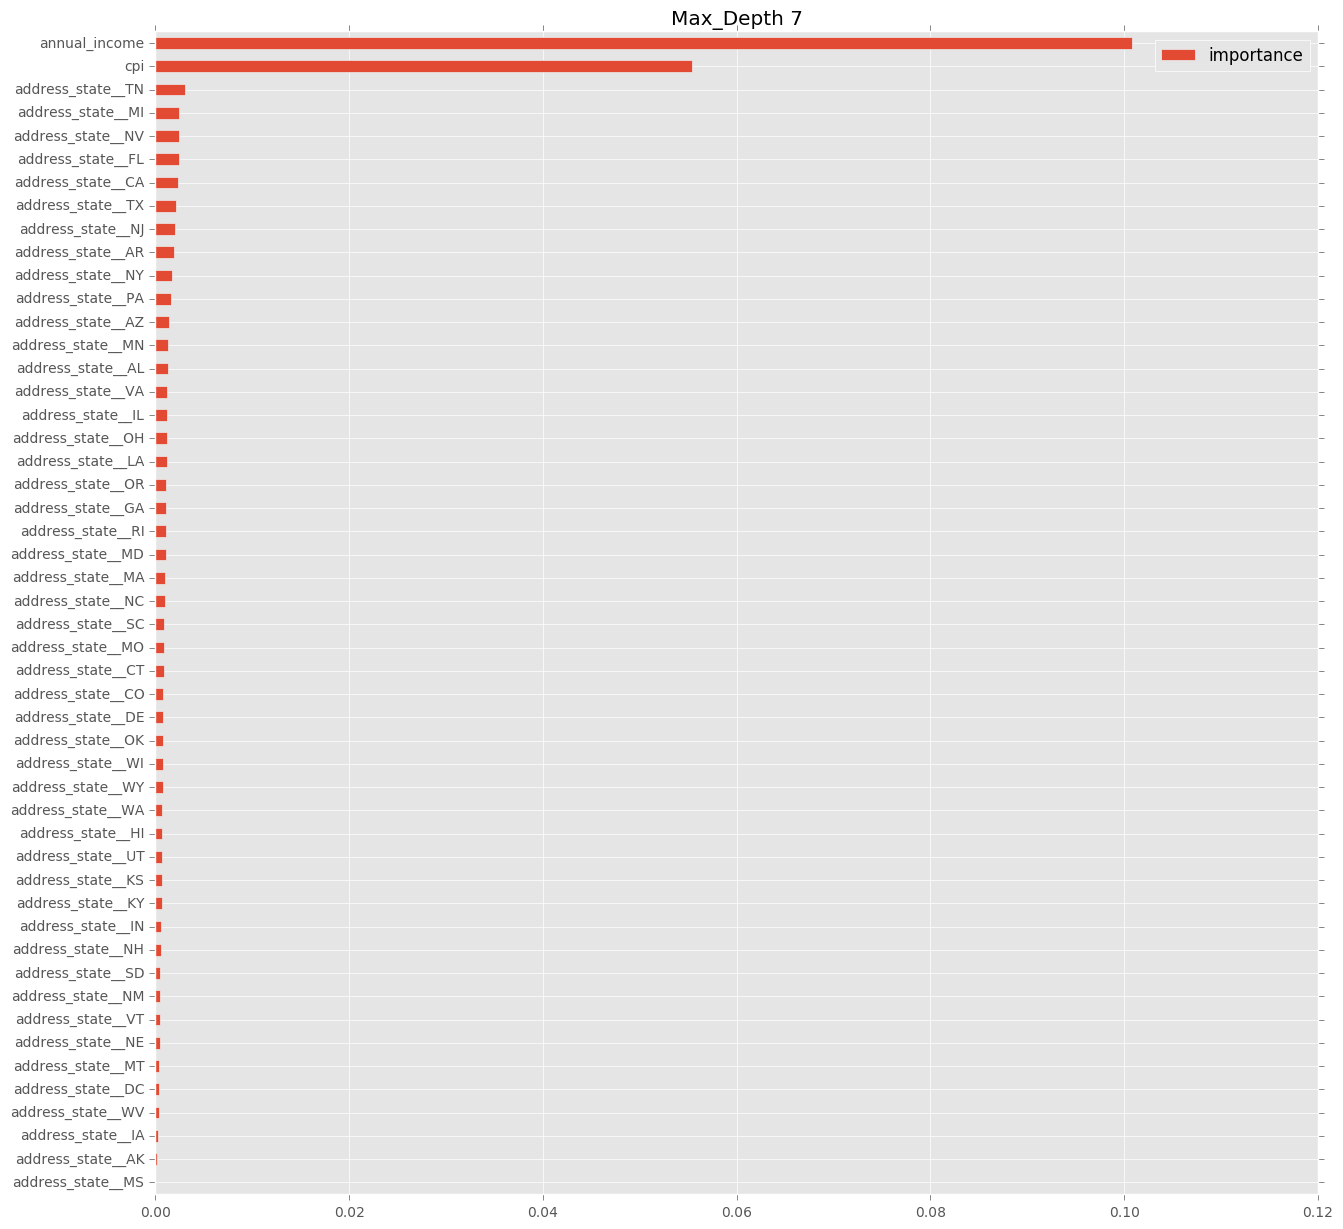

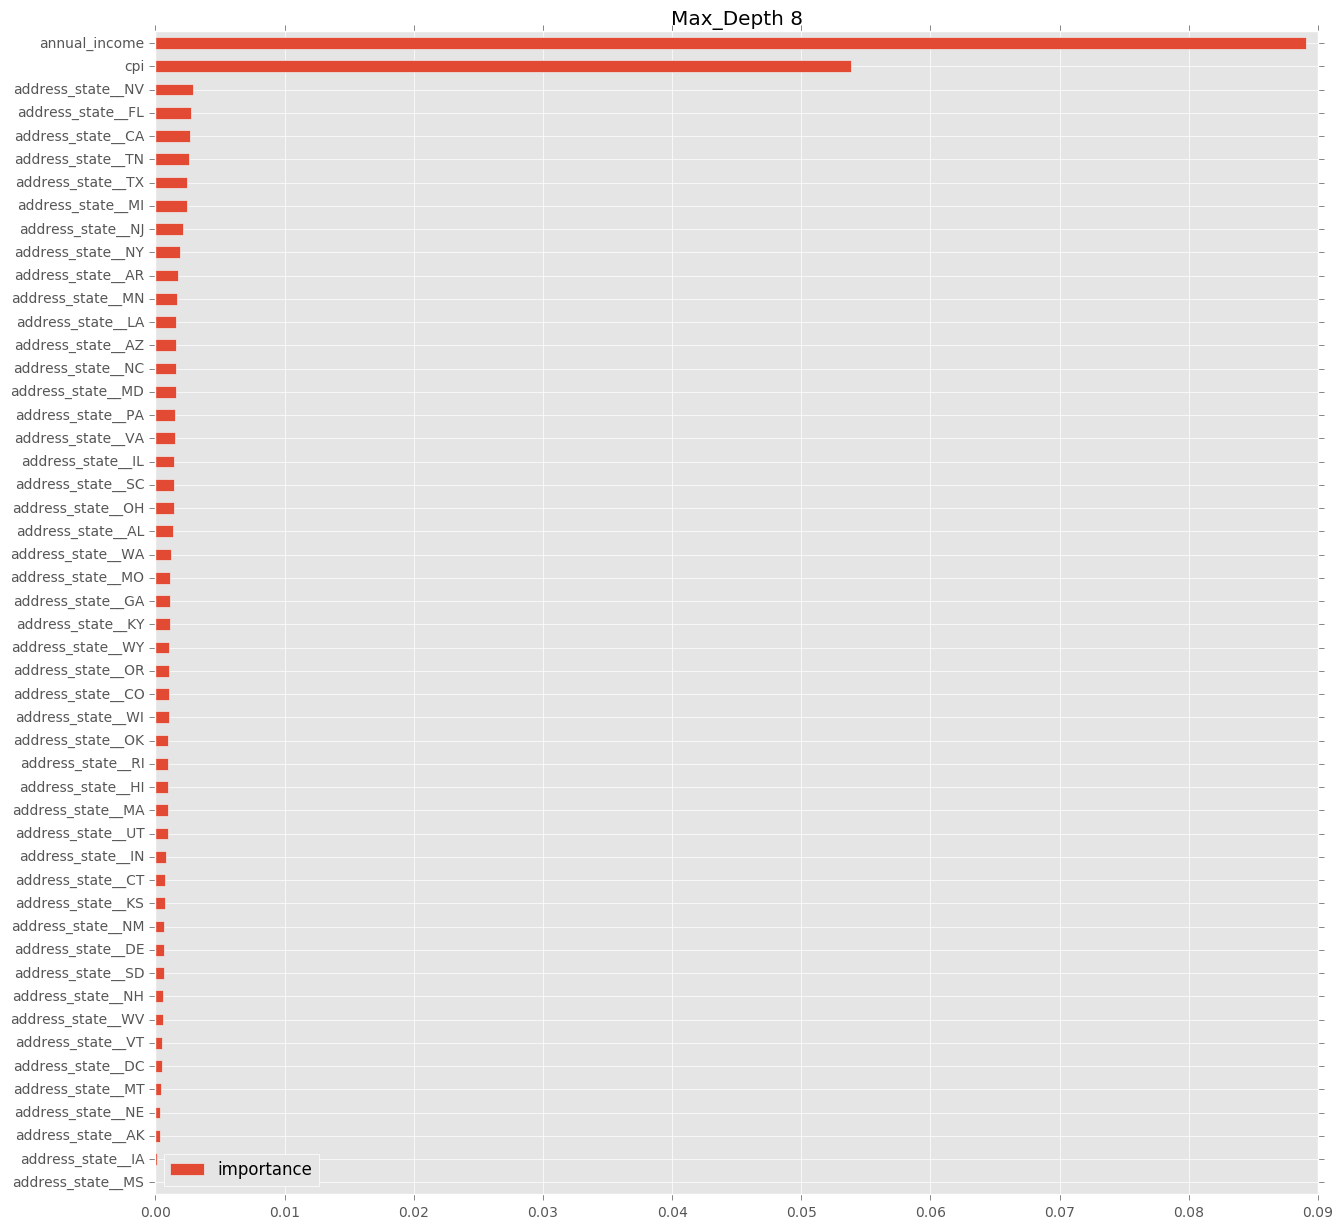

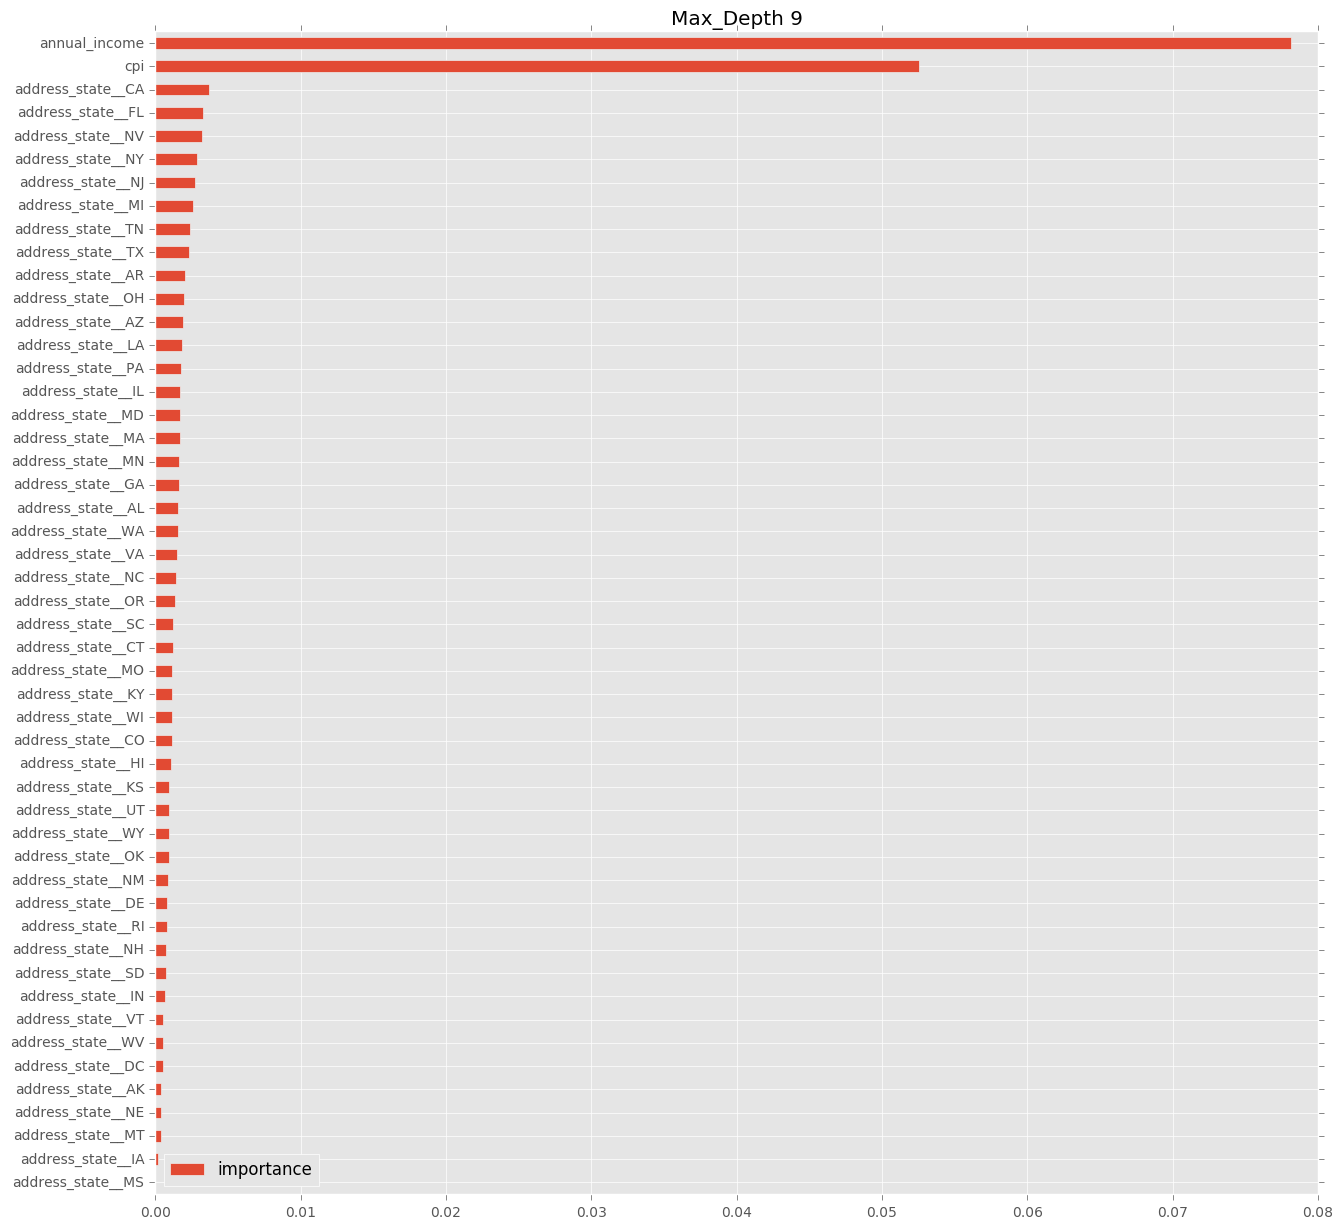

In [688]:
# One RF with all years combined; what predictors matter?
for md in range(2,10):
    yrs_in_2011_2013 = years.isin([2011, 2012, 2013])
    rf = RFC(random_state=1729,
         max_depth=md,
         n_estimators=300,
         oob_score=True
        ).fit(x_expanded[yrs_in_2011_2013], y[yrs_in_2011_2013])
    plt.figure(figsize=(15,15))
    pd.DataFrame(rf.feature_importances_, 
             index=x_expanded.columns,
             columns=['importance'],
             ).iloc[0:50,:].sort_values(by='importance',
                           ascending=True,
             ).plot(kind='barh', ax=plt.gca())
    plt.title("Max_Depth " + str(md))
    plt.show()

In [689]:
def eval_model_all_years(model_factory, columns = None, prob_threshold = 0.5, 
                         x = x_expanded, x_test = x_test_expanded, y = y, y_test = y_test):
    k = 5
    np.random.seed(1729)
    
    if columns is None:
        x_local = x
        x_local_test = x_test
    else:
        x_local = x[columns]
        x_local_test = x_test[columns]
        
    if True: # for yr in [2011, 2012, 2013]: # set(years.values):
        indexes = range(len(years))
        np.random.shuffle(indexes)

        cm_accum = np.zeros((2, 2))
        f1_accum = 0
        score = 0
        weighted_score = 0

        # k-fold cross-validation
        for i in range(k):
            train_indexes = list(indexes[0:len(indexes)*i/k]) + list(indexes[len(indexes)*(i+1)/k:])
            test_indexes = indexes[len(indexes)*i/k:len(indexes)*(i+1)/k]
        
            #print "TRAIN ", train_indexes
            #print 'TEST', test_indexes
            #print "Y", y.iloc[test_indexes]
            
            # model = model_factory().fit(x_expanded[years==yr], y[years==yr])
            # score = model.score(x_expanded[years==yr], y[years==yr]) / k
            model = model_factory().fit(x_local.iloc[train_indexes,:], y.iloc[train_indexes])
            y_hat = model.predict(x_local)
            score += model.score(x_local.iloc[test_indexes], y.iloc[test_indexes]) / k
            y_hat_weighted = (model.predict_proba(x_local)[:,0] > prob_threshold)[test_indexes]
            weighted_score += (y.iloc[test_indexes][y_hat_weighted]).mean() / k
            cm_accum += confusion_matrix(y.iloc[test_indexes], y_hat[test_indexes])
            f1_accum += f1_score(y.iloc[test_indexes], y_hat[test_indexes], pos_label = 1) / k
        
        # but also test against the x_test
        test_y_hat = (model.predict_proba(x_local_test)[:,0] > prob_threshold)
        test_score = (y_test == test_y_hat).mean()
        test_precision = 1- y_test[test_y_hat].mean()
        test_f1 = f1_score(y_test, test_y_hat, pos_label = 1) / k

        # project revenue
        profit_mm = round(((36 * installments[test_y_hat == True].sum()) \
                           + (recoveries_avg * test_y_hat.sum()) \
                            - loan_amounts[test_y_hat == False].sum()) \
                           / float(10 ** 6))
        
        print "%d  score: %.3f  baseline: %.3f   wscore: %.3f   f1: %.3f  | test score %.3f  1-prec %.3f f1 %.3f  profit {:,.0f}MM".format(profit_mm)  \
        % (0, score, 1-y.mean(), 1-weighted_score, f1_accum, test_score, test_precision, test_f1)

# TODO: Confusion matrix (right now, we're not doing well enough to worry about that)
# TODO: Pretty-print
# TODO: Store results to allow side-by-side

In [690]:
def eval_model_by_year(model_factory, columns = None, prob_threshold = 0.5,
                        x = x_expanded, x_test = x_test_expanded, y = y, y_test = y_test):
    eval_model_all_years(model_factory, columns, prob_threshold, x, x_test, y, y_test)
    k = 5
    np.random.seed(1729)
    
    if columns is None:
        x_local = x
        x_local_test = x_test
    else:
        x_local = x[columns]
        x_local_test = x_test[columns]
        
    for yr in [2011, 2012, 2013]: # set(years.values):
        indexes = np.where(years == yr)[0]
        np.random.shuffle(indexes)

        cm_accum = np.zeros((2, 2))
        f1_accum = 0
        score = 0
        weighted_score = 0

        # k-fold cross-validation
        for i in range(k):
            train_indexes = list(indexes[0:len(indexes)*i/k]) + list(indexes[len(indexes)*(i+1)/k:])
            test_indexes = indexes[len(indexes)*i/k:len(indexes)*(i+1)/k]
        
            #print "TRAIN ", train_indexes
            #print 'TEST', test_indexes
            #print "Y", y.iloc[test_indexes]
            
            # model = model_factory().fit(x_expanded[years==yr], y[years==yr])
            # score = model.score(x_expanded[years==yr], y[years==yr]) / k
            model = model_factory().fit(x_local.iloc[train_indexes,:], y.iloc[train_indexes])
            y_hat = model.predict(x_local)
            score += model.score(x_local.iloc[test_indexes], y.iloc[test_indexes]) / k
            y_hat_weighted = (model.predict_proba(x_local)[:,0] > prob_threshold)[test_indexes]
            weighted_score += (y.iloc[test_indexes][y_hat_weighted]).mean() / k
            cm_accum += confusion_matrix(y.iloc[test_indexes], y_hat[test_indexes])
            f1_accum += f1_score(y.iloc[test_indexes], y_hat[test_indexes], pos_label = 1) / k
        
        # but also test against the x_test
        test_score = model.score(x_local_test[years_test == yr], y_test[years_test == yr])
        test_y_hat = (model.predict_proba(x_local_test[years_test == yr])[:,0] > prob_threshold)
        test_precision = 1- y_test[years_test == yr][test_y_hat].mean()

        print "%d  score: %.3f  baseline: %.3f   wscore: %.3f   f1: %.3f  | test score %.3f  1-prec %.3f"  % (
            yr, score, 1-y[years==yr].mean(), 1-weighted_score, f1_accum, test_score, test_precision)

# TODO: Confusion matrix (right now, we're not doing well enough to worry about that)
# TODO: Pretty-print
# TODO: Store results to allow side-by-side

#### Models without PCA

In [691]:
eval_model_by_year(lambda: Log_Reg())

0  score: 0.844  baseline: 0.845   wscore: 0.848   f1: 0.043  | test score 0.153  1-prec 0.850 f1 0.052  profit 899MM
2011  score: 0.886  baseline: 0.887   wscore: 0.888   f1: 0.035  | test score 0.895  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.868   f1: 0.014  | test score 0.862  1-prec 0.864
2013  score: 0.816  baseline: 0.818   wscore: 0.824   f1: 0.098  | test score 0.822  1-prec 0.830


In [692]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'))

0  score: 0.643  baseline: 0.845   wscore: 0.905   f1: 0.353  | test score 0.367  1-prec 0.903 f1 0.031  profit 263MM
2011  score: 0.635  baseline: 0.887   wscore: 0.913   f1: 0.243  | test score 0.638  1-prec 0.928
2012  score: 0.637  baseline: 0.867   wscore: 0.916   f1: 0.310  | test score 0.611  1-prec 0.901
2013  score: 0.645  baseline: 0.818   wscore: 0.887   f1: 0.391  | test score 0.637  1-prec 0.887


In [693]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6)

0  score: 0.643  baseline: 0.845   wscore: 0.923   f1: 0.353  | test score 0.515  1-prec 0.921 f1 0.023  profit -59MM
2011  score: 0.635  baseline: 0.887   wscore: 0.915   f1: 0.243  | test score 0.638  1-prec 0.940
2012  score: 0.637  baseline: 0.867   wscore: 0.934   f1: 0.310  | test score 0.611  1-prec 0.919
2013  score: 0.645  baseline: 0.818   wscore: 0.909   f1: 0.391  | test score 0.637  1-prec 0.908


In [694]:
eval_model_by_year(lambda: QDA())

0  score: 0.183  baseline: 0.845   wscore: 0.864   f1: 0.268  | test score 0.801  1-prec 0.850 f1 0.018  profit -590MM
2011  score: 0.132  baseline: 0.887   wscore: 0.748   f1: 0.193  | test score 0.126  1-prec 0.914
2012  score: 0.161  baseline: 0.867   wscore: 0.929   f1: 0.237  | test score 0.156  1-prec 0.899
2013  score: 0.195  baseline: 0.818   wscore: 0.884   f1: 0.308  | test score 0.185  1-prec 0.846


In [695]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True))

In [696]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True), prob_threshold=0.85)

In [697]:
# TODO: Try again, this time fitting a regression against the payments received

In [698]:
# Curious -- what are the 95 CI for the baselines?
for yr in set(years.values):
    yr_n = (years == yr).sum()
    yr_def = (y[years == yr]).sum()
    yr_p = (y[years == yr]).mean()
    yr_se = (yr_p * (1.0-yr_p) / yr_n)
    print "y=%4d   n=%4d   d=%4d   p: %.3f | %.3f | %.3f" % (yr, yr_n, yr_def, yr_p - 1.96*yr_se, yr_p, yr_p + 1.96*yr_se)

y=2011   n=2521   d= 286   p: 0.113 | 0.113 | 0.114
y=2012   n=7475   d= 994   p: 0.133 | 0.133 | 0.133
y=2013   n=9723   d=1767   p: 0.182 | 0.182 | 0.182


In [699]:
# Default rate for small business is higher, right?
print y.mean()
print y[x_expanded.loan_purpose__small_business == 1].mean()

0.154521020336
0.230563002681


In [700]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), ['loan_purpose__small_business'])

0  score: 0.835  baseline: 0.845   wscore: 0.847   f1: 0.050  | test score 0.162  1-prec 0.850 f1 0.052  profit 879MM
2011  score: 0.714  baseline: 0.887   wscore: 0.856   f1: 0.070  | test score 0.874  1-prec 0.899
2012  score: 0.852  baseline: 0.867   wscore: 0.868   f1: 0.058  | test score 0.849  1-prec 0.865
2013  score: 0.816  baseline: 0.818   wscore: 0.820   f1: 0.042  | test score 0.821  1-prec 0.826


In [701]:
eval_model_by_year(lambda: RFC(
        random_state=1729,
        max_depth=5,
        n_estimators=300
        )
)

0  score: 0.845  baseline: 0.845   wscore: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.053  profit 909MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [702]:
eval_model_by_year(lambda: RFC(
        random_state=1729,
        max_depth=5,
        n_estimators=300
        )
)

0  score: 0.845  baseline: 0.845   wscore: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.053  profit 909MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [703]:
# TODO: try different depths

In [704]:
from sklearn.dummy import DummyClassifier
eval_model_by_year(lambda: DummyClassifier(strategy='constant', constant=0))

0  score: 0.845  baseline: 0.845   wscore: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.053  profit 909MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [705]:
# LogReg is doing well.. what are the largest coefficients?
lr = Log_Reg(class_weight='balanced').fit(x_expanded[years.isin([2011,2012,2013])], y[years.isin([2011,2012,2013])])
lr_coeff = pd.DataFrame(lr.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()

In [706]:
lr_coeff.sort_values('abs', ascending=False).coeff

employ_title__walmart                        -1.725939
employ_title__manager                        -1.484829
employ_title__U.S._Army                      -1.458575
employ_title__The_Home_Depot                 -1.417917
employ_title__United_Parcel_Service          -1.297963
employ_title__USPS                            1.035294
employ_title__United_States_Postal_Service   -0.997159
employ_title__Director                       -0.940348
employ_title__Department_of_Defense          -0.918240
employ_title__Home_Depot                      0.906000
employ_title__US_Army                        -0.900847
employ_title__JP_Morgan_Chase                -0.900770
employ_title__State_of_California            -0.888825
employ_title__United_States_Air_Force        -0.854343
employ_title__driver                          0.812821
address_state__IA                             0.803908
loan_purpose__renewable_energy                0.729859
employ_title__Driver                         -0.701258
loan_amoun

In [707]:
lr_probs = lr.predict_proba(x_expanded)[:,0]

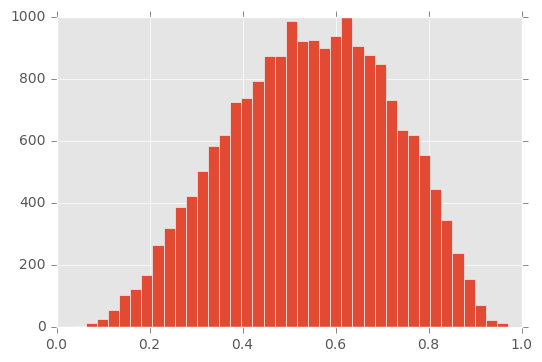

In [708]:
plt.hist(lr_probs ,bins=40)
plt.show()

In [709]:
1 - y.groupby([int(p*20)/20.0 for p in lr_probs]).mean()

0.00    1.000000
0.05    0.240000
0.10    0.542636
0.15    0.576512
0.20    0.638554
0.25    0.646341
0.30    0.709904
0.35    0.771469
0.40    0.794438
0.45    0.837446
0.50    0.858617
0.55    0.877220
0.60    0.897436
0.65    0.919110
0.70    0.939312
0.75    0.952229
0.80    0.971257
0.85    0.970803
0.90    0.978947
0.95    1.000000
Name: loan_status, dtype: float64

In [710]:
def eval_model_with_threshold(model_factory, columns=None):
    k = 5
    np.random.seed(1729)
    if columns is None:
        x_local = x_expanded
    else:
        x_local = x_expanded[columns]

    if True: # because old indent for loop
        indexes = range(len(y))
        np.random.shuffle(indexes)

        probs = np.ones_like(y) * -1

        for i in range(k):
            train_indexes = list(indexes[0:len(indexes)*i/k]) + list(indexes[len(indexes)*(i+1)/k:])
            test_indexes = indexes[len(indexes)*i/k:len(indexes)*(i+1)/k]
        
            model = model_factory().fit(x_local.iloc[train_indexes,:], y.iloc[train_indexes])
            probs_test = (model.predict_proba(x_local)[:,0]) #[test_indexes]
            probs = np.where([ii in test_indexes for ii in range(len(y))],  # slow but the only one I've found that works!
                             probs_test, probs)
            # print i, (probs == -1).sum(), (probs > 0).sum()
            
    thresholds = np.arange(0, 1, 0.05)
    plt.plot(thresholds,
             [1-y[probs > t].mean() for t in thresholds])
    plt.show()

    return probs

In [711]:
# probs = eval_model_with_threshold(lambda: Log_Reg())

In [712]:
# probs = eval_model_with_threshold(lambda: Log_Reg(class_weight='balanced'))

In [713]:
# VERY SLOW
#probs = eval_model_with_threshold(lambda: SVC(
#        random_state=1729,
#        probability=True))

#### Models with PCA

In [714]:
eval_model_by_year(lambda: Log_Reg(), x = x_expanded_pca, x_test = x_test_expanded_pca)

0  score: 0.845  baseline: 0.845   wscore: 0.848   f1: 0.039  | test score 0.152  1-prec 0.850 f1 0.052  profit 901MM
2011  score: 0.886  baseline: 0.887   wscore: 0.888   f1: 0.035  | test score 0.895  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.868   f1: 0.010  | test score 0.862  1-prec 0.864
2013  score: 0.816  baseline: 0.818   wscore: 0.823   f1: 0.085  | test score 0.823  1-prec 0.830


In [715]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), x = x_expanded_pca, x_test = x_test_expanded_pca)

0  score: 0.641  baseline: 0.845   wscore: 0.906   f1: 0.354  | test score 0.368  1-prec 0.904 f1 0.031  profit 258MM
2011  score: 0.631  baseline: 0.887   wscore: 0.916   f1: 0.249  | test score 0.630  1-prec 0.929
2012  score: 0.628  baseline: 0.867   wscore: 0.914   f1: 0.305  | test score 0.607  1-prec 0.901
2013  score: 0.645  baseline: 0.818   wscore: 0.888   f1: 0.393  | test score 0.636  1-prec 0.889


In [716]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, 
                   x = x_expanded_pca, x_test = x_test_expanded_pca)

0  score: 0.641  baseline: 0.845   wscore: 0.925   f1: 0.354  | test score 0.520  1-prec 0.923 f1 0.022  profit -73MM
2011  score: 0.631  baseline: 0.887   wscore: 0.921   f1: 0.249  | test score 0.630  1-prec 0.941
2012  score: 0.628  baseline: 0.867   wscore: 0.931   f1: 0.305  | test score 0.607  1-prec 0.921
2013  score: 0.645  baseline: 0.818   wscore: 0.910   f1: 0.393  | test score 0.636  1-prec 0.912


In [717]:
eval_model_by_year(lambda: QDA(), x = x_expanded_pca, x_test = x_test_expanded_pca)

0  score: 0.705  baseline: 0.845   wscore: 0.867   f1: 0.270  | test score 0.328  1-prec 0.869 f1 0.043  profit 439MM
2011  score: 0.687  baseline: 0.887   wscore: 0.896   f1: 0.194  | test score 0.726  1-prec 0.904
2012  score: 0.702  baseline: 0.867   wscore: 0.881   f1: 0.225  | test score 0.699  1-prec 0.876
2013  score: 0.707  baseline: 0.818   wscore: 0.841   f1: 0.288  | test score 0.689  1-prec 0.844


## NLP

In [718]:
data_nlp.columns

Index([u'address_state', u'annual_income', u'cpi', u'delinq_2_yrs',
       u'desc_len', u'desc_matrix_reduce', u'desc_word_count', u'description',
       u'dti', u'earliest_credit', u'employ_length', u'employ_title', u'gdp',
       u'home_owner', u'id', u'initial_list_status', u'inquiry_6_mos',
       u'installment', u'interest_rate', u'ipr', u'issue_date', u'loan_amount',
       u'loan_purpose', u'loan_status', u'loan_subgrade', u'loan_term',
       u'misspell_count', u'misspell_count_norm', u'months_since_last_record',
       u'open_accounts', u'recoveries', u'revol_util', u'rir',
       u'total_accounts', u'unemploy', u'verif_status', u'vocab_count',
       u'vocab_count_norm'],
      dtype='object')